Importing the neccessary packages

In [1]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, pdist
from io import StringIO
from scipy.spatial import cKDTree

from sklearn.metrics import silhouette_score
from geopy.distance import geodesic
import matplotlib.cm as cm 
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
from networkx.algorithms.community import greedy_modularity_communities
import pickle

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import geopandas as gpd
import networkx as nx
import seaborn as sns
import numpy as np
from collections import Counter

from geopy.distance import geodesic
from Levenshtein import distance
from haversine import haversine, Unit

from collections import Counter
import pandas as pd

In [ ]:
day = 1

df_common = pd.DataFrame()
file_path = f"/mnt/common-ssd/mizsakma/Puskas/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({day})/stops.txt"

df = pd.read_csv(file_path)
df_common = pd.concat([df_common, df], ignore_index=True)
df_common = df_common.drop_duplicates()

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700,NaN,NaN,NaN,NaN,NaN
1,002138,Kőbánya alsó vasútállomás,47.483139,19.127891,NaN,NaN,NaN,2.0,NaN
2,003002,Puskás Ferenc Stadion M,47.500368,19.103406,NaN,NaN,NaN,NaN,NaN
3,003103,"Káposztásmegyer, Mogyoródi-patak",47.598778,19.121447,NaN,NaN,NaN,NaN,NaN
4,003105,Bécsi út / Vörösvári út,47.548817,19.029722,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...
5915,LMXKPJ,Keleti pályaudvar [J],47.500166,19.081876,LMXKPJ,2.0,CSLMXKPB,2.0,NaN
5916,LMXKPK,Keleti pályaudvar [K],47.499635,19.080700,LMXKPK,2.0,CSLMXKPB,1.0,NaN
5917,LMXKPL,Keleti pályaudvar [L],47.499448,19.080676,LMXKPL,2.0,CSLMXKPB,2.0,NaN
5918,LMXKPM,Keleti pályaudvar [M],47.499376,19.080515,LMXKPM,2.0,CSLMXKPB,2.0,NaN


In [3]:
myprojection_latlong_2 = 4326
stops = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_common["stop_lon"], df_common["stop_lat"]), crs = myprojection_latlong_2)

def calculate_geodesic_distance(point1, point2):
    return geodesic((point1.y, point1.x), (point2.y, point2.x)).meters

stops = gpd.GeoDataFrame(geometry=stops["geometry"])
stops.crs = myprojection_latlong_2
stops = stops.to_crs(myprojection_latlong_2)

num_points = len(stops)
geodesic_distance_matrix = np.zeros((num_points, num_points))

# calculating geodesic distances between pairs of points represented by longitude and latitude coordinates.
#The distance matrix initialized here will be populated with actual distance values in subsequent step

In [4]:
try:

    puskas_matrix = np.load("/mnt/common-ssd/mizsakma/Multilin_15p_concept/multilin_15_city/Budapest/puskas_week.npy")
    puskas_matrix_condensed = squareform(puskas_matrix)
    
except FileNotFoundError:

    for i in tqdm(range(num_points)):

        for j in range(num_points):

            if i != j:

                distance = calculate_geodesic_distance(stops.iloc[i].geometry, stops.iloc[j].geometry)

                geodesic_distance_matrix[i, j] = distance
    
    np.save("puskas_week.npy", geodesic_distance_matrix)

In [5]:
#hierarchical clustering on the distance matrix 
linkage_matrix = linkage(puskas_matrix_condensed, method="complete")
dist_threshold = 150
clusters = fcluster(linkage_matrix, dist_threshold, criterion="distance")
df_common["clust"] = clusters

In [6]:
stop_clusters = df_common.groupby('stop_name')['clust'].unique()
stop_clusters_count = stop_clusters.apply(len)
stop_clusters_count_df = stop_clusters_count.reset_index()
stop_clusters_count_df.columns = ['stop_name', 'num_clusters']
df_common_2 = df_common[df_common['stop_name'].str.endswith(('M', 'H'))]
clust_names_2 = set(df_common_2['stop_name'])
clust_names_2.add('Haller utca / Soroksári út')
clust_names_2.add('Astoria')
clust_names_2 = list(clust_names_2)

for i in clust_names_2:
        filtered_df = df_common[df_common['stop_name'] == i]
        unique_clusters = filtered_df['clust'].unique()
        if len(unique_clusters) >= 2:
            same = unique_clusters[:-1]
            clust_num = unique_clusters[-1]
            df_common.loc[df_common['clust'].isin(same), 'clust'] = clust_num

# However in the case of metros and and the bigger squares which we would like to consider as stop the 150m treshold is not enough. 
# But luckily we can do it automatically, because in the case of  and hév (literally metro but it has an other name in hungarian) at each stop there is an M or a H.
# For example in the case of Örs Vezér tere M+H the maximum distance between two stops is 500 meters, while both of them is called Örs vezér tere M+H.
# Determine how many distinct clusters are associated with each stop in the transportation network. It is necessary because accurately creating nodes is essential for a working network

# Creating dictionaries the the stops's parent station ID and the parent station ID's 

In [7]:
def calculate_geodesic_distance(point1, point2):
    return geodesic(point1, point2).meters

In [8]:
df_2 = df_common.sort_values('clust')
df_2 = df_2.drop_duplicates()
df_2['quant'] = df_2.groupby('clust').transform('size')
df_2['quant'].value_counts()

df.loc[df_2['location_type'] == 1.0, 'parent_station'] = df_2['stop_id']
df_2_b = df_2[df_2['quant'] > 1]
df_2_b['parent_station'] = df_2_b['parent_station'].astype(str)
grouped = df_2_b.groupby('clust')
max_parent_by_clust = grouped['parent_station'].transform(
    lambda x: np.where(x != '', x, x.max()))

df_2[df_2['parent_station'].notna()].shape[0]
df_2_b['parent_station'] = max_parent_by_clust
df_2_b['parent_station'] = df_2_b['parent_station'].astype(str)
grouped = df_2_b.groupby('clust')

max_parent_by_clust = grouped['parent_station'].transform(
    lambda x: np.where(x.notna(), x, x.max()))

df_2_b['parent_station'] = np.where(
    (max_parent_by_clust == 'nan') & (df_2_b['quant'] > 1),
    df_2_b.groupby('clust')['stop_id'].transform(lambda x: x.iloc[0]),
    max_parent_by_clust
)
df_2_a = df_2[df_2['quant'] <= 1]
lonely_stops = (df_2_a['quant'] == 1) & (df_2_a['parent_station'].isna())

df_2_a.loc[lonely_stops, 'parent_station'] = df_2_a.loc[lonely_stops, 'stop_id']
df_2 = pd.concat([df_2_a, df_2_b], ignore_index=True)

/tmp/ipykernel_3910569/1969656888.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_b['parent_station'] = df_2_b['parent_station'].astype(str)
/tmp/ipykernel_3910569/1969656888.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_b['parent_station'] = max_parent_by_clust
/tmp/ipykernel_3910569/1969656888.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
walking_speed = 5.1  # Walking speed in km/h
walking_speed_mps = walking_speed * 1000 / 3600  # Convert km/h to m/s

stop_pairs = df_2[['stop_id', 'stop_lat', 'stop_lon', 'clust']].drop_duplicates()

data = []

for clust, group in tqdm(stop_pairs.groupby('clust')):
    stop_ids = group['stop_id'].values
    coords = group[['stop_lat', 'stop_lon']].values

    for i in range(len(stop_ids)):
        for j in range(i + 1, len(stop_ids)):
            stop_id_1 = stop_ids[i]
            stop_id_2 = stop_ids[j]
            point1 = (coords[i][0], coords[i][1])
            point2 = (coords[j][0], coords[j][1])

            distance = calculate_geodesic_distance(point1, point2)

            if distance / walking_speed_mps <= 600:
                data.append((stop_id_1, stop_id_2, distance))
                data.append((stop_id_2, stop_id_1, distance))

df_distances = pd.DataFrame(data, columns=['stop_id', 'stop_id_to', 'travel_duration'])
df_distances['travel_duration'] = df_distances['travel_duration'] / walking_speed
df_2['stop_lon'] = df_2.groupby('parent_station')['stop_lon'].transform('mean')
df_2['stop_lat'] = df_2.groupby('parent_station')['stop_lat'].transform('mean')

  0%|          | 0/2346 [00:00<?, ?it/s]

100%|██████████| 2346/2346 [00:03<00:00, 640.88it/s]


In [ ]:
file_path = f"/mnt/common-ssd/mizsakma/Puskas/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({day})"

pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",", dtype={'stop_headsign': 'object'})

print(pure_stop_times[pure_stop_times['stop_id'].isin(df_common['stop_id'])]['stop_id'].nunique(), 
      df_common[df_common['stop_id'].isin(pure_stop_times['stop_id'])]['stop_id'].nunique(),
      pure_stop_times[pure_stop_times['stop_id'].isin(df_2['stop_id'])]['stop_id'].nunique(), 
      df_2[df_2['stop_id'].isin(pure_stop_times['stop_id'])]['stop_id'].nunique())

routes = pd.read_csv(file_path + "/routes.txt", sep=",")

trips = pd.read_csv(file_path + "/trips.txt", sep=",", dtype={'route_id': 'object'})

pure_stop_times = pure_stop_times.merge(df_common[['stop_id', 'clust', 'parent_station', 'stop_name']], on='stop_id', how='left')
pure_stop_times.loc[pure_stop_times['parent_station'].notna(), 'stop_id'] = pure_stop_times['parent_station']
pure_stop_times.loc['stop_id'] = pure_stop_times['parent_station']

routes = routes[['route_id', 'route_type']]
trips = trips[['route_id', 'trip_id', 'service_id', 'direction_id']]
trips = pd.merge(trips, routes, on='route_id', how='right')
pure_stop_times = pure_stop_times.merge(trips[['trip_id', 'route_id', 'route_type', 'service_id', 'direction_id']], on='trip_id', how='left')

pure_stop_times['stop_id_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['stop_id'].shift(-1)
pure_stop_times['arrival_time_stop_to'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['arrival_time'].shift(-1)
pure_stop_times['distance_travaled'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['shape_dist_traveled'].shift(-1)

#deleting the terminals and loops
pure_stop_times = pure_stop_times[pure_stop_times['arrival_time_stop_to'].notna()]
pure_stop_times = pure_stop_times[pure_stop_times['stop_id'] != pure_stop_times['stop_id_to']]

pure_stop_times['arrival_hour'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[0]))
pure_stop_times['arrival_minute'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[1]))
pure_stop_times['arrival_second'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[2]))

pure_stop_times['departure_hour'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[0]))
pure_stop_times['departure_minute'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[1]))
pure_stop_times['departure_second'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[2]))

pure_stop_times['arrival_time'] = pd.to_datetime({
    'year': 2020,  
    'month': 9,   
    'day': 20 + day,      
    'hour':     pure_stop_times['arrival_hour'],
    'minute':   pure_stop_times['arrival_minute'],
    'second':   pure_stop_times['arrival_second'] })

pure_stop_times['departure_time'] = pd.to_datetime({
    'year':2020,
    'month':9,
    'day': 20 + day,
    'hour':pure_stop_times['departure_hour'],
    'minute':pure_stop_times['departure_minute'],
    'second':pure_stop_times['departure_second']
})

pure_stop_times['arrival_time_only'] = pure_stop_times['arrival_time'].dt.time
pure_stop_times['departure_time_only'] = pure_stop_times['departure_time'].dt.time
pure_stop_times = pure_stop_times[pure_stop_times['stop_id'].isin(df_common['stop_id'])]
pure_stop_times = pure_stop_times[pure_stop_times['departure_hour'] < 24]

pure_stop_times['edge_frequency'] = pure_stop_times.groupby(['departure_hour', 'route_id', 'stop_id', 'stop_id_to']).transform('size')
pure_stop_times['edge_frequency_trip'] = pure_stop_times.groupby(['departure_hour', 'stop_id', 'stop_id_to', 'trip_id']).transform('size')

pure_stop_times['travel_duration'] = pure_stop_times['arrival_time'] - pure_stop_times['departure_time']
pure_stop_times['travel_duration'] = pure_stop_times['travel_duration'].dt.total_seconds().astype(int)
pure_stop_times.loc[pure_stop_times['travel_duration'] == 0, 'travel_duration'] = 30
pure_stop_times['distance_travaled'] = pure_stop_times['distance_travaled'] - pure_stop_times['shape_dist_traveled']

5430 5430 5430 5430


# Combining bubi data and public transport

### cluster type

In [ ]:
bubi_data = pd.read_csv('/mnt/common-ssd/mizsakma/Bubi+bkk/data/edge_mol_bubi_09_21 (1).csv', dtype={'Rental_place': 'string', 'Return_place': 'string'})
bubi_data = bubi_data.drop_duplicates()
pure_stop_times['clust_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['clust'].shift(-1)
pure_stop_times = pure_stop_times[pure_stop_times['clust'] != pure_stop_times['clust_to']]

pure_stop_times_2 = pure_stop_times[pure_stop_times['departure_hour'] == 15][
    ['route_id', 'clust', 'clust_to', 'travel_duration', 'direction_id']
].drop_duplicates()

grouped_df = pure_stop_times_2.groupby(
    ['route_id', 'clust', 'clust_to', 'direction_id']
)['travel_duration'].mean().reset_index()

pure_stop_times_2['clust'] = pure_stop_times_2['clust'].astype(str)

proba_network = nx.MultiDiGraph()

for idx, row in grouped_df.iterrows():
    proba_network.add_edge(
        row['clust'], 
        row['clust_to'],
        weight=row['travel_duration'], 
        route_id=row['route_id']
    )

In [16]:
print('number of nodes:', nx.number_of_nodes(proba_network))
print('number of edges:', nx.number_of_edges(proba_network))

if not nx.is_strongly_connected(proba_network):
    sccs = list(nx.strongly_connected_components(proba_network))
    print(f"Number of strongly connected components: {len(sccs)}")

    largest_scc = max(sccs, key=len)
    print(f"Largest component size: {len(largest_scc)}")

    largest_component_network = proba_network.subgraph(largest_scc).copy()

    print('number of nodes in largest component:', nx.number_of_nodes(largest_component_network))
    print('number of edges in largest component:', nx.number_of_edges(largest_component_network))

number of nodes: 2289
number of edges: 10786
Number of strongly connected components: 213
Largest component size: 2020
number of nodes in largest component: 2020
number of edges in largest component: 10188


In [18]:
bubi_stops = bubi_data[['Rental_place', 'Start_lat', 'Start_lng']].drop_duplicates()
bkk_stops = df_common[df_common['clust'].isin(largest_component_network.nodes())][['stop_name', 'stop_lat', 'stop_lon', 'clust']].drop_duplicates()

bubi_stops = bubi_stops.reset_index(drop=True)
bkk_stops = bkk_stops.reset_index(drop=True)

bubi_coords = bubi_stops[['Start_lat', 'Start_lng']].to_numpy()
bkk_coords = bkk_stops[['stop_lat', 'stop_lon']].to_numpy()

tree = cKDTree(bkk_coords)

bubi_returns = bubi_data[['Return_place', 'End_lat', 'End_lng']].drop_duplicates().reset_index(drop=True)
return_coords = bubi_returns[['End_lat', 'End_lng']].to_numpy()

distances_return, indices_return = tree.query(return_coords, k=1)

closest_bkk_returns = pd.DataFrame({
    'bubi_station': bubi_returns['Return_place'],
    'closest_bkk_stop_to': bkk_stops.loc[indices_return, 'stop_name'].values,
    'clust': bkk_stops.loc[indices_return, 'clust'].values,
    'euclidean_distance_deg_to': distances_return
})

In [20]:
bkk_routes = []

bubi_to_bkk_stop = dict(zip(closest_bkk_returns['bubi_station'], closest_bkk_returns['closest_bkk_stop_to']))
stop_id_lookup = dict(zip(df_common['stop_name'], df_common['clust']))

for _, row in tqdm(bubi_data.iterrows()):
    rental_name = row['Rental_place']
    return_name = row['Return_place']
    bubi_time = row['avg_duration_min'] * 60

    source_bkk_stop = bubi_to_bkk_stop.get(rental_name)
    target_bkk_stop = bubi_to_bkk_stop.get(return_name)

    source_id = stop_id_lookup.get(source_bkk_stop)
    target_id = stop_id_lookup.get(target_bkk_stop)

    if source_id is None or target_id is None:
        bkk_routes.append({
            'Bubi_from': rental_name,
            'Bubi_to': return_name,
            'Time': None,
            'Bubi Time': bubi_time
        })
        continue

    try:
        travel_time = nx.shortest_path_length(
            largest_component_network,
            source=source_id,
            target=target_id,
            weight='weight'
        )
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        travel_time = 'Not possible to travel there'

    bkk_routes.append({
        'Bubi_from': rental_name,
        'Bubi_to': return_name,
        'Bkk Time': travel_time,
        'Bubi Time' : bubi_time
    })

bkk_route_df = pd.DataFrame(bkk_routes)

6015it [00:07, 839.72it/s] 


In [22]:
bubi_bkk_cluster_time = bkk_route_df[
    (bkk_route_df['Bkk Time'] != 0) &
    (bkk_route_df['Bkk Time'] != 'Not possible to travel there')
]
bkk_no_travel = bkk_route_df[bkk_route_df['Bkk Time'] == 'Not possible to travel there']

In [40]:
bubi_bkk_cluster_time['bkk_better'] = np.where(bubi_bkk_cluster_time['Bkk Time'] <= bubi_bkk_cluster_time['Bubi Time'], 1, 0)

/tmp/ipykernel_3910569/1781424116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubi_bkk_cluster_time['bkk_better'] = np.where(bubi_bkk_cluster_time['Bkk Time'] <= bubi_bkk_cluster_time['Bubi Time'], 1, 0)


In [53]:
import folium

bubi_data_from_unique = bubi_data[['Rental_place', 'Start_lat', 'Start_lng']].drop_duplicates(subset='Rental_place')
bubi_data_to_unique = bubi_data[['Return_place', 'End_lat', 'End_lng']].drop_duplicates(subset='Return_place')

bubi_bkk_place = (
    bubi_bkk_cluster_time
    .merge(bubi_data_from_unique[['Rental_place', 'Start_lat', 'Start_lng']], left_on='Bubi_from', right_on='Rental_place', how='left')
    .merge(bubi_data_to_unique[['Return_place', 'End_lat', 'End_lng']], left_on='Bubi_to', right_on='Return_place', how='left')
    .drop_duplicates()
)

trips = bubi_bkk_place[bubi_bkk_place['bkk_better'] == 0][['Start_lat', 'Start_lng', 'End_lat', 'End_lng']].copy()

# Budapest center
budapest_coords = [47.4979, 19.0402]
m = folium.Map(location=budapest_coords, zoom_start=12)
for idx, row in trips.iterrows():
    # Draw a line from start to end
    folium.PolyLine(
        locations=[(row['Start_lat'], row['Start_lng']), (row['End_lat'], row['End_lng'])],
        color="blue",
        weight=2,
        opacity=0.5
    ).add_to(m)
    # Optional: Add markers
    folium.CircleMarker([row['Start_lat'], row['Start_lng']], radius=3, color='green', fill=True, fill_opacity=0.7).add_to(m)
    folium.CircleMarker([row['End_lat'], row['End_lng']], radius=3, color='red', fill=True, fill_opacity=0.7).add_to(m)

In [54]:
m

<Axes: xlabel='Bkk Time', ylabel='Count'>

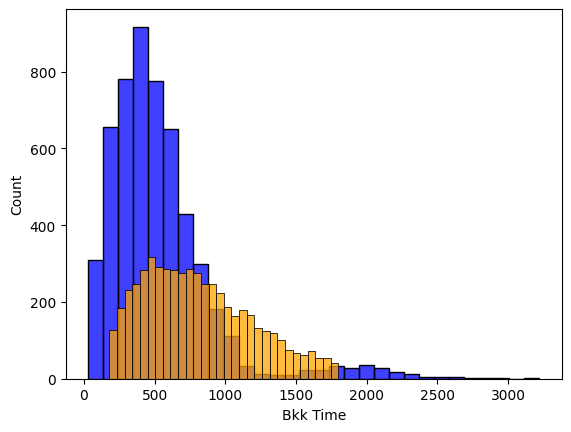

In [26]:
import seaborn as sns

sns.histplot(bubi_bkk_cluster_time['Bkk Time'], bins = 30, color = 'blue')
sns.histplot(bubi_bkk_cluster_time['Bubi Time'], bins = 30, color = 'orange')

Olyan map ahol a bubi utakat felrajzoljuk, amikor gyorsabb lassabb és ugyanannyi

/tmp/ipykernel_3910569/3842153258.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


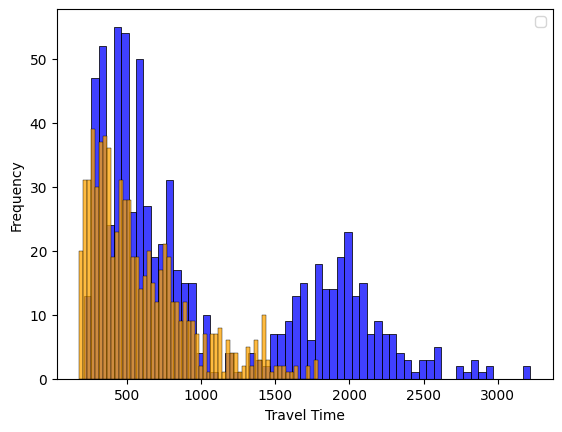

In [ ]:
#Lolipop plot kéne
import seaborn as sns

bubi_bkk_cluster_time_only_bubi_better = bubi_bkk_cluster_time[bubi_bkk_cluster_time['bkk_better'] == 1].copy()
sns.histplot(bubi_bkk_cluster_time_only_bubi_better['Bkk Time'], bins = 60, color = 'blue')
sns.histplot(bubi_bkk_cluster_time_only_bubi_better['Bubi Time'], bins = 60, color = 'orange')

plt.xlabel('Travel Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

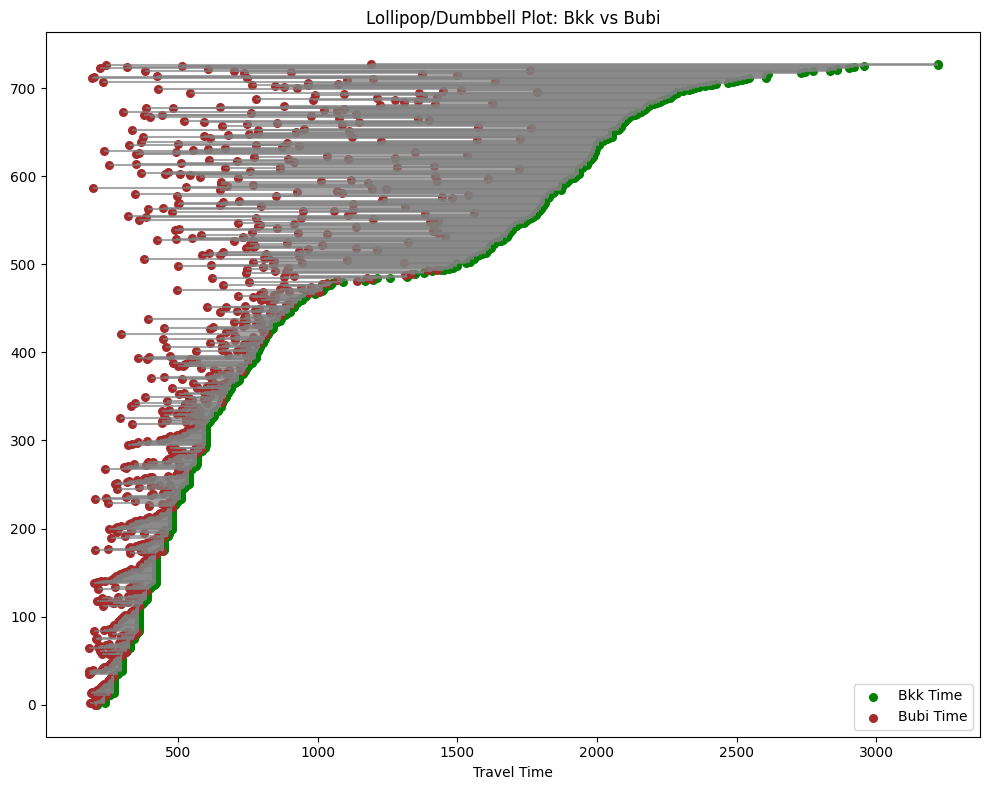

In [29]:
df = bubi_bkk_cluster_time_only_bubi_better.copy().reset_index(drop=True)
df['Label'] = df.index.astype(str)  

# Sorting
df = df.sort_values(by=['Bkk Time', 'Bubi Time']).reset_index(drop=True)
y = np.arange(df.shape[0])

plt.figure(figsize=(10, 8))
plt.hlines(y, df['Bkk Time'], df['Bubi Time'], color='gray', alpha=0.7)

plt.scatter(df['Bkk Time'], y, color='green', label='Bkk Time', s=30)
plt.scatter(df['Bubi Time'], y, color='brown', label='Bubi Time', s=30)

plt.xlabel('Travel Time')
plt.title('Lollipop/Dumbbell Plot: Bkk vs Bubi')
plt.legend()
plt.tight_layout()
plt.show()


### stop_id type

In [40]:
df_distances['route_id'] = 'walking'
df_distances['travel_duration'] = 180

pure_stop_times_2 = pure_stop_times[pure_stop_times['departure_hour'] == 15][
    ['route_id', 'stop_id', 'stop_id_to', 'travel_duration', 'direction_id']
].drop_duplicates()

grouped_df = pure_stop_times_2.groupby(
    ['route_id', 'stop_id', 'stop_id_to', 'direction_id']
)['travel_duration'].mean().reset_index()

pure_stop_times_2['stop_id'] = pure_stop_times_2['stop_id'].astype(str)

df_distances = df_distances[df_distances['stop_id'].isin(pure_stop_times_2['stop_id'].unique())]
proba_stop_times = pd.concat([grouped_df, df_distances], ignore_index=True)

proba_network = nx.MultiDiGraph()

for idx, row in proba_stop_times.iterrows():
    proba_network.add_edge(
        row['stop_id'], 
        row['stop_id_to'],
        weight=row['travel_duration'], 
        route_id=row['route_id']
    )

print('number of nodes:', nx.number_of_nodes(proba_network))
print('number of edges:', nx.number_of_edges(proba_network))

if not nx.is_strongly_connected(proba_network):
    sccs = list(nx.strongly_connected_components(proba_network))
    print(f"Number of strongly connected components: {len(sccs)}")

    largest_scc = max(sccs, key=len)
    print(f"Largest component size: {len(largest_scc)}")

    largest_component_network_stops = proba_network.subgraph(largest_scc).copy()

    print('number of nodes in largest component:', nx.number_of_nodes(largest_component_network_stops))
    print('number of edges in largest component:', nx.number_of_edges(largest_component_network_stops))

number of nodes: 5847
number of edges: 26078
Number of strongly connected components: 970
Largest component size: 4839
number of nodes in largest component: 4839
number of edges in largest component: 20783


In [41]:
bubi_stops = bubi_data[['Rental_place', 'Start_lat', 'Start_lng']].drop_duplicates()
bkk_stops = df_common[df_common['stop_id'].isin(largest_component_network_stops.nodes())][['stop_name', 'stop_lat', 'stop_lon', 'stop_id']].drop_duplicates()

bubi_stops = bubi_stops.reset_index(drop=True)
bkk_stops = bkk_stops.reset_index(drop=True)

bubi_coords = bubi_stops[['Start_lat', 'Start_lng']].to_numpy()
bkk_coords = bkk_stops[['stop_lat', 'stop_lon']].to_numpy()

tree = cKDTree(bkk_coords)

bubi_returns = bubi_data[['Return_place', 'End_lat', 'End_lng']].drop_duplicates().reset_index(drop=True)
return_coords = bubi_returns[['End_lat', 'End_lng']].to_numpy()

distances_return, indices_return = tree.query(return_coords, k=1)

closest_bkk_returns = pd.DataFrame({
    'bubi_station': bubi_returns['Return_place'],
    'closest_bkk_stop_to': bkk_stops.loc[indices_return, 'stop_name'].values,
    'stop_id': bkk_stops.loc[indices_return, 'stop_id'].values,
    'euclidean_distance_deg_to': distances_return
})

In [43]:
bkk_routes = []

bubi_to_bkk_stop = dict(zip(closest_bkk_returns['bubi_station'], closest_bkk_returns['closest_bkk_stop_to']))
stop_id_lookup = dict(zip(df_common['stop_name'], df_common['clust']))

for _, row in tqdm(bubi_data.iterrows()):
    rental_name = row['Rental_place']
    return_name = row['Return_place']
    bubi_time = row['avg_duration_min'] * 60

    source_bkk_stop = bubi_to_bkk_stop.get(rental_name)
    target_bkk_stop = bubi_to_bkk_stop.get(return_name)

    source_id = stop_id_lookup.get(source_bkk_stop)
    target_id = stop_id_lookup.get(target_bkk_stop)

    if source_id is None or target_id is None:
        bkk_routes.append({
            'Bubi_from': rental_name,
            'Bubi_to': return_name,
            'Time': None,
            'Bubi Time': bubi_time
        })
        continue

    try:
        travel_time = nx.shortest_path_length(
            largest_component_network,
            source=source_id,
            target=target_id,
            weight='weight'
        )
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        travel_time = 'Not possible to travel there'

    bkk_routes.append({
        'Bubi_from': rental_name,
        'Bubi_to': return_name,
        'Bkk Time': travel_time,
        'Bubi Time' : bubi_time
    })

bkk_route_from_stops_df = pd.DataFrame(bkk_routes)

6015it [00:08, 692.01it/s]


In [44]:
bkk_route_from_stops_df[(bkk_route_from_stops_df['Time'].notna()) & 
                        (bkk_route_from_stops_df['Time'] != 'Not possible to travel there')]

KeyError: 'Time'

## DFS

In [ ]:
def find_all_paths_within_weight_limit(graph, start_node, weight_limit):
    def dfs(current_node, current_path, current_weight, visited, prev_route):
        if current_weight > weight_limit:
            return

        reachable_nodes.add(current_node)
        all_paths.append((list(current_path), current_weight))

        for neighbor in graph.successors(current_node):
            if neighbor not in visited:
                for edge_key in graph[current_node][neighbor]:
                    edge_data = graph[current_node][neighbor][edge_key]
                    edge_weight = edge_data['weight']
                    edge_route = edge_data['route_id']

                    total_weight = current_weight + edge_weight

                    if (
                        prev_route is not None and
                        edge_route != prev_route and
                        edge_route != 'walking' and
                        prev_route != 'walking'
                    ):
                        total_weight += 180  

                    if total_weight > weight_limit:
                        continue

                    visited.add(neighbor)
                    current_path.append(neighbor)

                    dfs(neighbor, current_path, total_weight, visited, edge_route)

                    current_path.pop()
                    visited.remove(neighbor)

    all_paths = []
    reachable_nodes = set()

    dfs(start_node, [start_node], 0, set([start_node]), None)

    return all_paths, reachable_nodes


paths, reachable_nodes = find_all_paths_within_weight_limit(largest_component_network, grouped_df['stop_id'].iloc[0], 600)
print(f"Number of paths: {len(paths)}")
print(f"Reachable stops within 600s: {len(reachable_nodes)}")

Number of paths: 3302
Reachable stops within 600s: 107


In [ ]:
results_dic = {}

for stop in tqdm(nx.nodes(largest_component_network)):
    results_dic[stop] = find_all_paths_within_weight_limit(largest_component_network, stop, 600)

100%|██████████| 4948/4948 [02:40<00:00, 30.88it/s] 


In [ ]:
with open('Budapest_10min_dfs.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

## Centrality calculations

In [ ]:
pure_stop_times_centrality = pd.DataFrame()

df_common_2 = df_common[df_common['stop_id'].isin(largest_component_network.nodes())].copy()
pure_stop_times_centrality = pd.merge(pure_stop_times, df_common_2[['stop_id', 'clust', 'stop_lat', 'stop_lon', 'stop_name']], on = ['stop_id', 'clust'], how = 'left')

pure_stop_times_centrality['clust_id_to'] = pure_stop_times_centrality.groupby(
    ['route_id', 'trip_id', 'service_id', 'route_type']
)['clust'].shift(-1)

pure_stop_times_centrality = pure_stop_times_centrality[
    pure_stop_times_centrality['clust_id_to'] != pure_stop_times_centrality['clust']
].drop_duplicates()

pure_stop_times_centrality_graph = pure_stop_times_centrality[
    pure_stop_times_centrality['departure_hour'] == 15
][['clust', 'clust_id_to', 'travel_duration']].drop_duplicates()

pure_stop_times_centrality_graph = pure_stop_times_centrality_graph.groupby(
    ['clust', 'clust_id_to'], as_index=False
)['travel_duration'].mean()

full_graph = nx.from_pandas_edgelist(
    pure_stop_times_centrality_graph, 
    source='clust', 
    target='clust_id_to', 
    edge_attr='travel_duration',
    create_using=nx.Graph()
)

eigenvector_centrality = nx.eigenvector_centrality(full_graph, max_iter=1000)
degree_centrality = nx.degree_centrality(full_graph)
closeness_centrality = nx.closeness_centrality(full_graph)
betweenness_centrality = nx.betweenness_centrality(full_graph)

centrality_df = pd.DataFrame({
    "Node": list(full_graph.nodes()),
    "Eigenvector Centrality": [eigenvector_centrality[node] for node in full_graph.nodes()],
    "Degree Centrality": [degree_centrality[node] for node in full_graph.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in full_graph.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in full_graph.nodes()]
})

In [ ]:
finalized_centrality_df = pd.merge(df_common[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'clust']], centrality_df, left_on = 'clust', right_on = 'Node', how = 'left')
finalized_centrality_df = finalized_centrality_df[finalized_centrality_df['stop_id'].isin(largest_component_network.nodes())]

In [ ]:
finalized_centrality_df.to_csv('Budapest_stops_centralities.csv')

In [ ]:
centrality_df = centrality_df[centrality_df['stop_id'].isin(largest_component_network.nodes())]
centrality_df

,Node,Eigenvector Centrality,Degree Centrality,Closeness Centrality,Betweenness Centrality,stop_id,clust,stop_lat,stop_lon,stop_name
0,1.0,3.134719e-15,0.000443,0.033464,0.000000,044369,1,47.175605,18.941796,Ráckeve
2,2.0,1.620608e-14,0.000886,0.034622,0.000886,CSF04632,2,47.227924,18.946067,Szigetszentmárton-Szigetújfalu
5,6.0,8.065061e-14,0.001329,0.035862,0.001771,009749,6,47.270708,18.956638,Szigetcsép H
6,6.0,8.065061e-14,0.001329,0.035862,0.001771,CSF04627,6,47.270231,18.956263,Szigetcsép
9,5.0,7.802397e-14,0.000886,0.035861,0.000000,008809,5,47.264682,18.970417,"Szigetcsép, községháza"
...,...,...,...,...,...,...,...,...,...,...
5776,2427.0,4.271374e-04,0.000886,0.080364,0.000852,F00966,2427,47.495569,19.048402,Vigadó tér
5777,2427.0,4.271374e-04,0.000886,0.080364,0.000852,F00967,2427,47.495614,19.048322,Vigadó tér
5778,2433.0,4.758213e-04,0.000886,0.080796,0.000666,F00924,2433,47.493105,19.050566,Petőfi tér
5779,2429.0,5.503501e-04,0.000886,0.081818,0.000087,F00982,2429,47.495371,19.052782,Szervita tér


In [ ]:
centrality_df.to_csv("Budapest_stops_with_centrality.csv", index=False)

## plot

In [ ]:
import folium
filtered_df = df_common[df_common['stop_id'].isin(largest_component_network.nodes())]

stop_info_dict = {
    row['stop_id']: {
        'lat': row['stop_lat'],
        'lon': row['stop_lon'],
        'clust': row['clust']
    }
    for _, row in filtered_df.iterrows()
}

nx.set_node_attributes(largest_component_network, stop_info_dict)
center_lat = filtered_df['stop_lat'].mean()
center_lon = filtered_df['stop_lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define a color palette for clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

clusters = filtered_df['clust'].unique()
cmap = cm.get_cmap('tab10', len(clusters))
cluster_to_color = {
    clust: colors.to_hex(cmap(i))
    for i, clust in enumerate(clusters)
}

# Add markers to the map
for node in largest_component_network.nodes(data=True):
    stop_id = node[0]
    attr = node[1]
    lat = attr.get('lat')
    lon = attr.get('lon')
    clust = attr.get('clust')
    color = cluster_to_color.get(clust, 'blue')  # fallback color

    folium.CircleMarker(
        location=(lat, lon),
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Stop ID: {stop_id}, Cluster: {clust}"
    ).add_to(m)

# Add edges as lines between connected stops
for u, v in largest_component_network.edges():
    node_u = largest_component_network.nodes[u]
    node_v = largest_component_network.nodes[v]

    lat_u, lon_u = node_u.get('lat'), node_u.get('lon')
    lat_v, lon_v = node_v.get('lat'), node_v.get('lon')

    if None not in (lat_u, lon_u, lat_v, lon_v):  # Make sure coordinates exist
        folium.PolyLine(
            locations=[(lat_u, lon_u), (lat_v, lon_v)],
            color="red",
            weight=1,
            opacity=0.5
        ).add_to(m)

# Display the map
m
